In [114]:
import numpy as np
import pandas as pd
from numba import njit, jit

from math import log, sqrt, pi, exp, erf, ceil, floor, cos, sin, e
from scipy.stats import norm, pearsonr
from scipy.stats.mstats import gmean

from matplotlib import pyplot as plt
from tqdm import tqdm, trange
from time import perf_counter
import gc

import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

""" Plt font size """
plt.rcParams['font.size'] = '13'

# Code from Example

In [2]:
def initialize_grid(max_iter_time, plate_length, boundary_value):

    # Initialize solution: the grid of u(k, i, j)
    u = np.empty((max_iter_time, plate_length, plate_length))

    # Initial condition everywhere inside the grid
    u_initial = 0.0

    # Boundary conditions (fixed temperature)
    u_top = boundary_value
    u_left = 0.0
    u_bottom = 0.0
    u_right = 0.0

    # Set the initial condition
    u.fill(u_initial)

    # Set the boundary conditions
    u[:, (plate_length-1):, :] = u_top
    u[:, :, :1] = u_left
    u[:, :1, 1:] = u_bottom
    u[:, :, (plate_length-1):] = u_right


    print("\nInitial 2-D grid in spatial dimension for time snapshot t=0 is listed below\n")
    print(u[0,:,:])
    return u

In [3]:
#Initialize plate length and max time iterations

plate_length = 50
max_iter_time = 500
boundary_value = 100

initial_grid = initialize_grid(max_iter_time, plate_length, boundary_value)

alpha = 2.0
delta_x = 1

# Calculated params (\Delta t should obey the FTCS condition for stability)
delta_t = (delta_x ** 2)/(4 * alpha)
print("\nUsing a timestep size of \Delta t = ", delta_t)
gamma = (alpha * delta_t) / (delta_x ** 2)


Initial 2-D grid in spatial dimension for time snapshot t=0 is listed below

[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0. 100. 100. ... 100. 100.   0.]]

Using a timestep size of \Delta t =  0.125


In [4]:
# Calculate u iteratively on the grid based on the equation derived above

def calculate(u):
    for k in range(0, max_iter_time-1, 1):
        for i in range(1, plate_length-1, delta_x):
            for j in range(1, plate_length-1, delta_x):
                u[k + 1, i, j] = gamma * (u[k][i+1][j] + u[k][i-1][j] + u[k][i][j+1] + u[k][i][j-1] - 4*u[k][i][j]) + u[k][i][j]

    return u

In [5]:
def plotheatmap(u_k, k):
  # Clear the current plot figure
    plt.clf()
    plt.title(f"Temperature at t = {k*delta_t:.3f} unit time")
    plt.xlabel("x")
    plt.ylabel("y")

    # This is to plot u_k (u at time-step k)
    plt.pcolormesh(u_k, cmap=plt.cm.jet, vmin=0, vmax=100)
    plt.colorbar()
    return plt

In [6]:
# Calculate final grid
final_grid = calculate(initial_grid)

# Plot the animation for the solution in time steps

def animate(k):
    plotheatmap(final_grid[k], k)


anim = animation.FuncAnimation(plt.figure(), animate, interval=1,frames=max_iter_time, repeat=False)
# anim.save("heat_equation_solution.gif")
anim

<Figure size 432x288 with 0 Axes>

# Code 0:

In [7]:
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def bottom_boundary_condition(K,T,S_min, r, t):
    return np.zeros(t.shape)

def top_boundary_condition(K,T,S_max, r, t):
    return S_max-np.exp(-r*(T-t))*K

def final_boundary_condition(K,T,S):
    return np.maximum(S-K,0)

In [8]:
def compute_abc( K, T, sigma, r, S, dt, dS ):
    # a = .5 *
    a = -sigma**2 * S**2/(2* dS**2 ) + r*S/(2*dS)
    b = r + sigma**2 * S**2/(dS**2)
    c = -sigma**2 * S**2/(2* dS**2 ) - r*S/(2*dS)
    return a,b,c

def compute_lambda( a,b,c ):
    return scipy.sparse.diags( [a[1:],b,c[:-1]],offsets=[-1,0,1])

def compute_W(a,b,c, V0, VM):
    M = len(b)+1
    W = np.zeros(M-1)
    W[0] = a[0]*V0
    W[-1] = c[-1]*VM
    return W

In [9]:
from numpy import log as ln
def price_call_explicit(K, T, r, sigma, N, M):
    """"
    N: Time Steps
    M: Price Steps
    """
    # Choose the shape of the grid
    dt = T/N
    S_min = 0
    S_max = K*np.exp(8*sigma*np.sqrt(T))
    dS = (S_max-S_min)/M
    S = np.linspace(S_min,S_max,M+1)  # convert to log space
    # print(S)

    t = np.linspace(0,T,N+1)
    V = np.zeros((N+1,M+1)) #...

    # Set the boundary conditions
    V[:,-1] = top_boundary_condition(K,T,S_max,r,t)
    V[:,0]  = bottom_boundary_condition(K,T,S_max,r,t)
    V[-1,:] = final_boundary_condition(K,T,S)

    # Apply the recurrence relation
    a,b,c  = compute_abc(K,T,sigma,r,S[1:-1],dt,dS)
    # print(a, b, c)
    Lambda = compute_lambda( a,b,c)
    print(Lambda.toarray())
    identity = scipy.sparse.identity(M-1)

    for i in range(N,0,-1):
        W = compute_W(a, b, c, V[i,0], V[i,M])
        # print(W, "\n")  #  ;   break

        # Use `dot` to multiply a vector by a sparse matrix
        V[i-1,1:M] = (identity-Lambda*dt).dot( V[i,1:M] ) - W*dt

    return V, t, S

In [10]:
V, t, S = price_call_explicit( K=99, T=1., r=.05, sigma=.2, N=10, M=10)
V

[[ 0.09  -0.045  0.     0.     0.     0.     0.     0.     0.   ]
 [-0.03   0.21  -0.13   0.     0.     0.     0.     0.     0.   ]
 [ 0.    -0.105  0.41  -0.255  0.     0.     0.     0.     0.   ]
 [ 0.     0.    -0.22   0.69  -0.42   0.     0.     0.     0.   ]
 [ 0.     0.     0.    -0.375  1.05  -0.625  0.     0.     0.   ]
 [ 0.     0.     0.     0.    -0.57   1.49  -0.87   0.     0.   ]
 [ 0.     0.     0.     0.     0.    -0.805  2.01  -1.155  0.   ]
 [ 0.     0.     0.     0.     0.     0.    -1.08   2.61  -1.48 ]
 [ 0.     0.     0.     0.     0.     0.     0.    -1.395  3.29 ]]


array([[0.00000000e+00, 1.20266316e-01, 5.97245851e+00, 5.30780073e+01,
        1.01990293e+02, 1.51016046e+02, 2.00050259e+02, 2.49084931e+02,
        2.98118698e+02, 3.47150260e+02, 3.96178497e+02],
       [0.00000000e+00, 9.68289807e-02, 5.40195477e+00, 5.25887925e+01,
        1.01515090e+02, 1.50542639e+02, 1.99577082e+02, 2.48611861e+02,
        2.97645872e+02, 3.46677823e+02, 3.95706459e+02],
       [0.00000000e+00, 7.57950381e-02, 4.82579955e+00, 5.20976635e+01,
        1.01037735e+02, 1.50066904e+02, 1.99101530e+02, 2.48136395e+02,
        2.97170634e+02, 3.46202988e+02, 3.95232056e+02],
       [0.00000000e+00, 5.72124496e-02, 4.24388901e+00, 5.16046592e+01,
        1.00558219e+02, 1.49588822e+02, 1.98623591e+02, 2.47658521e+02,
        2.96692970e+02, 3.45725738e+02, 3.94755274e+02],
       [0.00000000e+00, 4.11300967e-02, 3.65611639e+00, 5.11098210e+01,
        1.00076532e+02, 1.49108379e+02, 1.98143252e+02, 2.47178227e+02,
        2.96212862e+02, 3.45246056e+02, 3.94276102e+

In [11]:
S_, T_, V_ = [], [], []
for _row in range(V.shape[0]):
    for _column in range(V.shape[1]):
        S_.append(S[_column])
        T_.append(t[_row])
        V_.append(V[_row, _column])

S_, T_, V_ = np.array(S_), np.array(T_), np.array(V_)
S_.shape, T_.shape, V_.shape


((121,), (121,), (121,))

In [12]:
""" Getting Option Values from V """
# 1st Dimension = t
# 2nd Dimension = S value
# So to get the Value of an Option at t=0 for about ~100 : Based on the S vector

""" Get Value """
# V[0, 10]
S_, T_, V_

(array([  0.        ,  49.035021  ,  98.070042  , 147.105063  ,
        196.14008401, 245.17510501, 294.21012601, 343.24514701,
        392.28016801, 441.31518901, 490.35021002,   0.        ,
         49.035021  ,  98.070042  , 147.105063  , 196.14008401,
        245.17510501, 294.21012601, 343.24514701, 392.28016801,
        441.31518901, 490.35021002,   0.        ,  49.035021  ,
         98.070042  , 147.105063  , 196.14008401, 245.17510501,
        294.21012601, 343.24514701, 392.28016801, 441.31518901,
        490.35021002,   0.        ,  49.035021  ,  98.070042  ,
        147.105063  , 196.14008401, 245.17510501, 294.21012601,
        343.24514701, 392.28016801, 441.31518901, 490.35021002,
          0.        ,  49.035021  ,  98.070042  , 147.105063  ,
        196.14008401, 245.17510501, 294.21012601, 343.24514701,
        392.28016801, 441.31518901, 490.35021002,   0.        ,
         49.035021  ,  98.070042  , 147.105063  , 196.14008401,
        245.17510501, 294.21012601, 343.

In [13]:
t

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [14]:
S

array([  0.        ,  49.035021  ,  98.070042  , 147.105063  ,
       196.14008401, 245.17510501, 294.21012601, 343.24514701,
       392.28016801, 441.31518901, 490.35021002])

Text(0.5, 0.92, 'Option Value for Different Parameters')

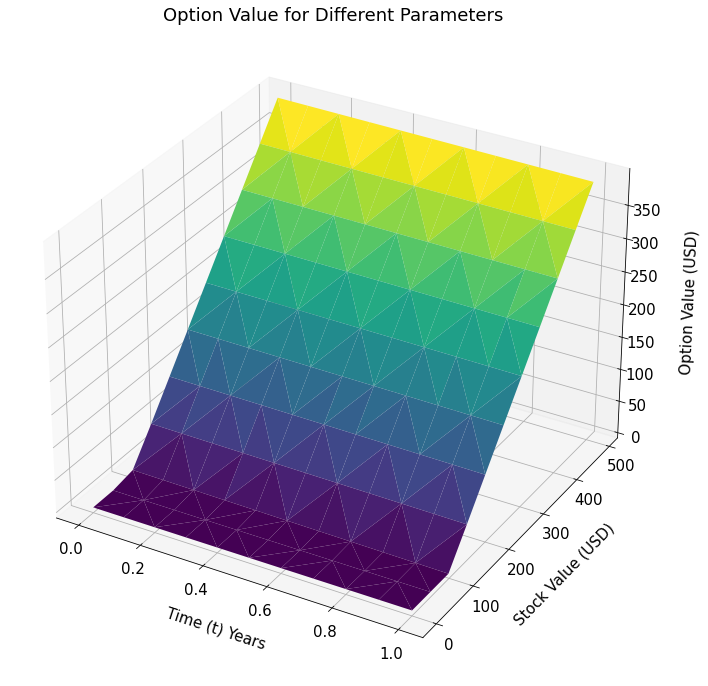

In [15]:
# gc.collect()
""" 3D Graph """
plt.rcParams['font.size'] = '15'

fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')
ax.plot_trisurf(T_, S_, V_, cmap='viridis', edgecolor='none')  # 'viridis' , cm.jet

# plt.xticks(plt.xticks()[0][1:-1], [f'{10**x*100:.2f}' for x in plt.xticks()[0][1:-1]])

ax.set_ylabel('\n\nStock Value (USD)')   ;   ax.set_xlabel('\n\n Time (t) Years')   ;   ax.set_zlabel('\n\n\nOption Value (USD)')
# ax.dist = 10
ax.set_title("Option Value for Different Parameters")


# Code 0.1

In [16]:
%matplotlib inline
# import numpy
import matplotlib.pyplot as pyplot
from matplotlib import rcParams
rcParams['figure.dpi'] = 100
rcParams['font.size'] = 16
rcParams['font.family'] = 'StixGeneral'

T = 1.       # expiry time
r = 0.06        # no-risk interest rate
sigma = 0.2    # volatility of underlying asset
E = 99.        # exercise price
S_max = 4*E    # upper bound of price of the stock (4*E)

In [17]:
def FTCS(C, N, M, dt, r, sigma):
    """using forward-time central-space scheme to solve the Black-Scholes equation for the call option price

    Arguments:
        C:       array of the price of call option
        N:       total number of time steps
        M:       total number of spatials grids
        dt:      time step
        r:       no-risk interest rate
        sigma:   volatility of the stock

    Returns:
        C:       array of the price of call option
    """
    index = np.arange(1,M)
    for n in range(N):

        C[1:-1] = 0.5 * (sigma**2 * index**2 * dt - r*index*dt) * C[0:-2] \
             +       (1 - sigma**2* index**2 *dt - r*dt) * C[1:-1]   \
             + 0.5 * (sigma**2 * index**2 * dt + r*index*dt) * C[2:]
    return C

# def FTCS_2(C, N, M, dt, r, sigma):
M, dt, r, sigma = 10, .1, .05, .2
index = np.arange(1,M)

B = np.zeros((M,M), dtype=float)
C = np.zeros((M,M), dtype=float)
for m in range(M):
    """ B - forward """
    B[m, m] = 1 - (1 - sigma**2* m**2 *dt - r*dt)
    if m > 0 :
        B[m-1, m] = - 0.5 * (sigma**2 * m**2 * dt + r*m*dt)
    if m != M - 1:
        B[m+1, m] = - 0.5 * (sigma**2 * m**2 * dt - r*m*dt)
    
    """ C - current """
    C[m, m] = 1 + (1 - sigma**2* m**2 *dt - r*dt)
    if m > 0 :
        C[m-1, m] = + 0.5 * (sigma**2 * m**2 * dt + r*m*dt)
    if m != M - 1:
        C[m+1, m] = + 0.5 * (sigma**2 * m**2 * dt - r*m*dt)
    
    
    
# B = np.arange(1,17).reshape((4,4))
# B[1,0]

B
C

# """
#     a = 0.5 * (sigma**2 * index**2 * dt - r*index*dt)
#     B = (1 - sigma**2* index**2 *dt - r*dt)
#     C = 0.5 * (sigma**2 * index**2 * dt + r*index*dt)
# """

# for n in range(N):


array([[ 1.995e+00,  4.500e-03,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  1.991e+00,  1.300e-02,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00],
       [ 0.000e+00, -5.000e-04,  1.979e+00,  2.550e-02,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  3.000e-03,  1.959e+00,  4.200e-02,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  1.050e-02,  1.931e+00,
         6.250e-02,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  2.200e-02,
         1.895e+00,  8.700e-02,  0.000e+00,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         3.750e-02,  1.851e+00,  1.155e-01,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+0

In [18]:
N = 2000       # number of time steps
M = 200        # number of space grids
dt = T/N       # time step
s = np.linspace(0, S_max, M+1)   # spatial grid (stock's price)

# initial condition & boundary condition
C = s - E
C = np.clip(C, 0, S_max-E)

In [19]:
C_exp = FTCS(C, N, M, dt, r, sigma)
print('the price of the call option should be around {}, \
if the current price of stock is 20 dollar.'.format(C_exp[int(M/2)]))

the price of the call option should be around 103.8285087708675, if the current price of stock is 20 dollar.


In [20]:
C_exp

array([0.00000000e+00, 5.92828558e-29, 4.46478511e-26, 1.12274833e-23,
       1.38963418e-21, 1.00930617e-19, 4.76765146e-18, 1.56824992e-16,
       3.77326366e-15, 6.89426137e-14, 9.85542849e-13, 1.12963289e-11,
       1.05995860e-10, 8.28953145e-10, 5.48947288e-09, 3.12196397e-08,
       1.54440950e-07, 6.72318544e-07, 2.60300440e-06, 9.05084450e-06,
       2.85167545e-05, 8.20870266e-05, 2.17514034e-04, 5.34247517e-04,
       1.22403209e-03, 2.63122101e-03, 5.33505901e-03, 1.02527964e-02,
       1.87580303e-02, 3.28039849e-02, 5.50376245e-02, 8.88885605e-02,
       1.38617287e-01, 2.09310467e-01, 3.06816307e-01, 4.37619606e-01,
       6.08662751e-01, 8.27124746e-01, 1.10017444e+00, 1.43471618e+00,
       1.83714584e+00, 2.31313332e+00, 2.86744404e+00, 3.50380780e+00,
       4.22483891e+00, 5.03200753e+00, 5.92565835e+00, 6.90507051e+00,
       7.96855069e+00, 9.11355050e+00, 1.03367997e+01, 1.16344465e+01,
       1.30021986e+01, 1.44354585e+01, 1.59294481e+01, 1.74793211e+01,
      

## PART 3 COS Method

In [102]:
r = 0.04
sigma = 0.3
S0 = 100
K = 110
T = 1

N = 64

In [109]:
def COS_method_val(S0, K, T, sigma, r, N):
    time1 = time.time()
    a = log(S0/K) + r * T - 12 * sqrt(sigma**2 * T)
    b = log(S0/K) + r * T + 12 * sqrt(sigma**2 * T)
    x = log(S0/K)
    d = b
    c = 0

    pi_daba = pi * ((d - a)/(b - a))
    pi_caba = pi * ((c - a)/(b - a))
    pi_xaba = pi * ((x - a)/(b - a))
    ed = e ** d
    ec = e ** c

    # Calculate the value of the call option
    V = 0

    for k in range(N + 1):
        k_pi_ba = (k * pi)/(b - a)

        # Trying to do the GBM
        i = complex(0,1)
        phi_GBM = np.real(e ** (i * k_pi_ba * (r - 0.5 * sigma **2) * T \
                - (0.5 * sigma**2 * T * k_pi_ba**2)) * e **(i * k * pi_xaba))

        # chi and psi
        chi = (1/(1 + (k_pi_ba)**2)) * (cos(k * pi_daba) * ed - cos(k * pi_caba) \
            + k_pi_ba * (sin(k * pi_daba) * ed - sin(k * pi_caba)))
        if k == 0:
            psi = d - c
        else:
            psi = (b - a)/(k * pi) * (sin(k * pi_daba) - sin(k * pi_caba))

        # payoff function and conditional density function with cosine coefficients
        Gk = 2/(b - a) * K * (chi - psi)
        Fk = 2/(b - a) * phi_GBM
        if k == 0:
            Fk *= 0.5

        V += Fk * Gk
        
        #print(V, Fk, Gk)

    V *= e**(-r * T) * ((b - a) / 2)
    
    time2 = time.time()
    
    cpu_time = time2 - time1
    
    return V, cpu_time

In [165]:
def bs_call(S0, K, T, sigma, r):
    d1 = (log(S0/K) + (r + sigma**2/2.) * T) / (sigma*sqrt(T))
    d2 = d1 - sigma * sqrt(T)

    V = S0*norm.cdf(d1) -K*exp(-r*T)*norm.cdf(d2)
    
    return V

V_BS = bs_call(S0, K, T, sigma, r)

print(V_BS)

15.128591111967928


In [183]:
S0_values = [100, 110, 120]
N_values = [32, 48, 64, 96, 128, 160, 192]

values = np.zeros((7, 6))

for i in range(len(N_values)):
    N = N_values[i]
    for j in range(len(S0_values)):
        S0 = S0_values[j]
        
        V_COS, cpu_time = COS_method_val(S0, K, T, sigma, r, N)
        V_BS = bs_call(S0, K, T, sigma, r)
        if i == 0:
            print(f"Black-Scholes value (S0 = {S0}):", V_BS, '\n')
#         print("COS-method value:   ", V_COS)
#         print("CPU time (in s):    ", cpu_time)
#         print("Difference (abs):   ", V_COS - V_BS)
#         print("Difference (%):     ", (V_COS - V_BS)/V_BS * 100)

        values[i][j * 2] = V_COS - V_BS
        values[i][j * 2 + 1] = cpu_time * 1000

values = pd.DataFrame(values, index=N_values, columns=['Difference', 'Runtime (msec)', 'Difference', 'Runtime (msec)', 'Difference', 'Runtime (msec)'])
print(values.to_latex())

Black-Scholes value (S0 = 100): 9.625357828843697 

Black-Scholes value (S0 = 110): 15.128591111967928 

Black-Scholes value (S0 = 120): 21.788808338829327 

\begin{tabular}{lrrrrrr}
\toprule
{} &    Difference &  Runtime (msec) &    Difference &  Runtime (msec) &    Difference &  Runtime (msec) \\
\midrule
32  &  3.406449e-04 &        0.141144 &  3.901955e-04 &        0.136137 &  4.216553e-04 &        0.138998 \\
48  &  2.258352e-09 &        0.215054 &  2.621238e-09 &        0.189066 &  2.800121e-09 &        0.168800 \\
64  & -7.105427e-14 &        0.220060 & -1.918465e-13 &        0.221968 &  1.456613e-13 &        0.217915 \\
96  & -7.105427e-14 &        0.305891 & -1.918465e-13 &        0.324011 &  1.456613e-13 &        0.308037 \\
128 & -7.105427e-14 &        0.399828 & -1.918465e-13 &        0.393152 &  1.456613e-13 &        0.401974 \\
160 & -7.105427e-14 &        0.532866 & -1.918465e-13 &        0.527143 &  1.456613e-13 &        0.477076 \\
192 & -7.105427e-14 &        0.569820

In [208]:
S0_values = [100, 110, 120]
N_values = np.linspace(1, 200, num=200, dtype=int)

COS_values_100 = np.zeros(200)
BS_values_100 = np.zeros(200)
COS_values_110 = np.zeros(200)
BS_values_110 = np.zeros(200)
COS_values_120 = np.zeros(200)
BS_values_120 = np.zeros(200)
errors = np.zeros(200)

for S0 in S0_values:
    
    for N in N_values:
        V_COS, cpu_time = COS_method_val(S0, K, T, sigma, r, N)
        V_BS = bs_call(S0, K, T, sigma, r)
        if S0 == 100:
            COS_values_100[N - 1] = V_COS
            BS_values_100[N - 1] = V_BS
            errors[N - 1] = np.abs(V_COS - V_BS)
        if S0 == 110:
            COS_values_110[N - 1] = V_COS
            BS_values_110[N - 1] = V_BS
        if S0 == 120:
            COS_values_120[N - 1] = V_COS
            BS_values_120[N - 1] = V_BS

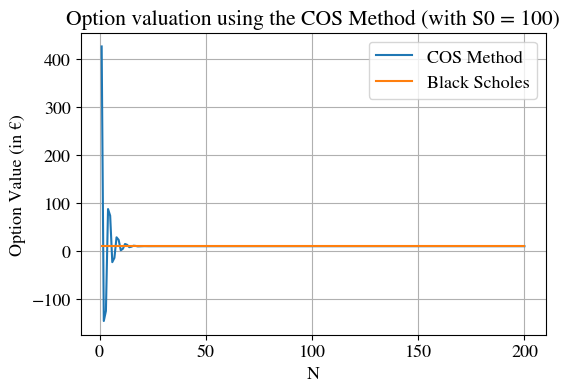

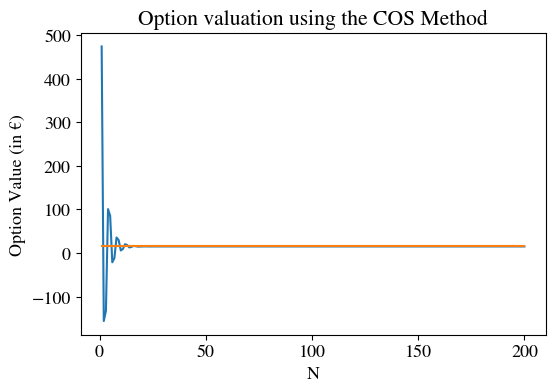

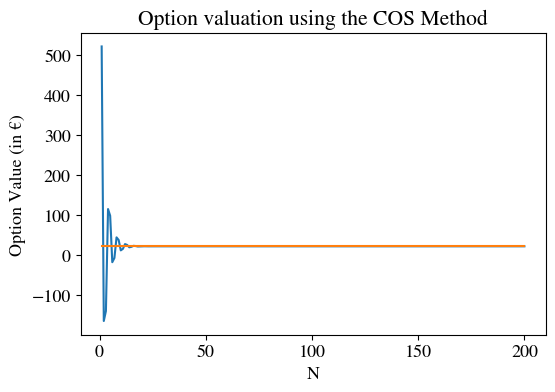

In [209]:
plt.plot(N_values, COS_values_100,  label='COS Method')
plt.plot(N_values, BS_values_100, label ="Black Scholes")
plt.title("Option valuation using the COS Method (with S0 = 100)")
plt.xlabel("N")
plt.ylabel("Option Value (in €)")
plt.grid()
plt.legend()
plt.show()

plt.plot(N_values, COS_values_110)
plt.plot(N_values, BS_values_110)
plt.title("Option valuation using the COS Method")
plt.xlabel("N")
plt.ylabel("Option Value (in €)")
plt.show()

plt.plot(N_values, COS_values_120)
plt.plot(N_values, BS_values_120)
plt.title("Option valuation using the COS Method")
plt.xlabel("N")
plt.ylabel("Option Value (in €)")
plt.show()

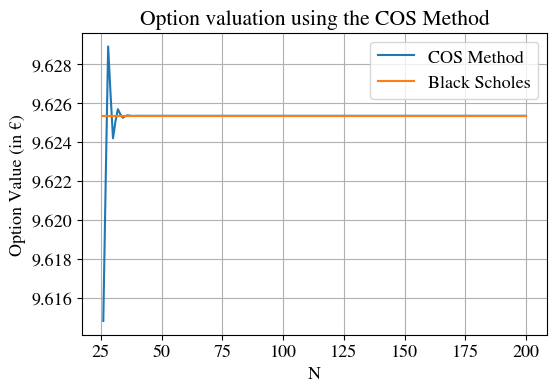

In [210]:
plt.plot(N_values[25:], COS_values_100[25:], label='COS Method')
plt.plot(N_values[25:], BS_values_100[25:], label ="Black Scholes")
plt.title("Option valuation using the COS Method (with S0 = 100)")
plt.title("Option valuation using the COS Method")
plt.xlabel("N")
plt.ylabel("Option Value (in €)")
plt.grid()
plt.legend()
plt.show()

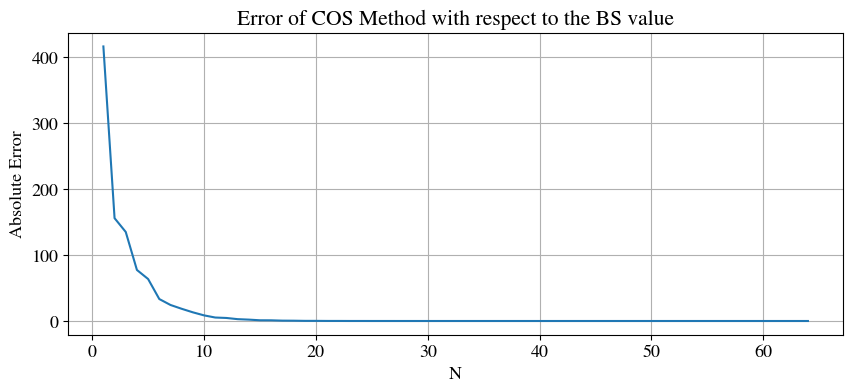

In [235]:
# quad = np.zeros(64)
# quad[0] = errors[0]

# for i in range(1, 64):
#     quad[i] = np.sqrt(quad[i - 1])

fig = plt.figure(figsize=(10,4))
plt.plot(N_values[:64], errors[:64])
# plt.plot(N_values[:64], quad)
plt.title("Error of COS Method with respect to the BS value")
plt.xlabel("N")
plt.ylabel("Absolute Error")
plt.grid()
plt.show()